In [3]:
import os, textwrap, itertools

print(os.listdir("/kaggle/input"))


['airbus-ship-detection']


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
os.listdir("/kaggle/input/airbus-ship-detection")


['test_v2',
 'sample_submission_v2.csv',
 'train_ship_segmentations_v2.csv',
 'train_v2']

In [6]:
df = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv")

In [7]:
segmented_mask = df["EncodedPixels"].notna()
ship_count = df.groupby("ImageId").count()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_stats/counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_kws, weights=weights, density=density)


Text(0.5, 0, '0 or 1')

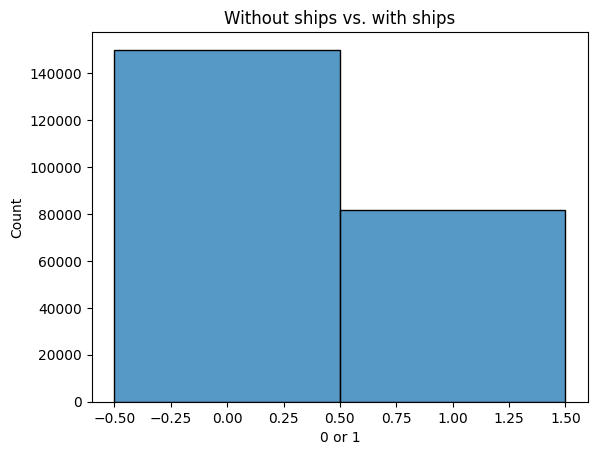

In [8]:
sns.histplot(segmented_mask, discrete=True)  # szerintem itt nem veszed figyelembe, hogy egy képen több hajó is lehet
plt.title("Without ships vs. with ships")
plt.xlabel("0 or 1")

## Szerintem így lenne helyes

In [9]:
pics_with_ship_count = len(ship_count[ship_count["EncodedPixels"] > 0])
pics_without_ship_count = len(df[df["EncodedPixels"].isna()])

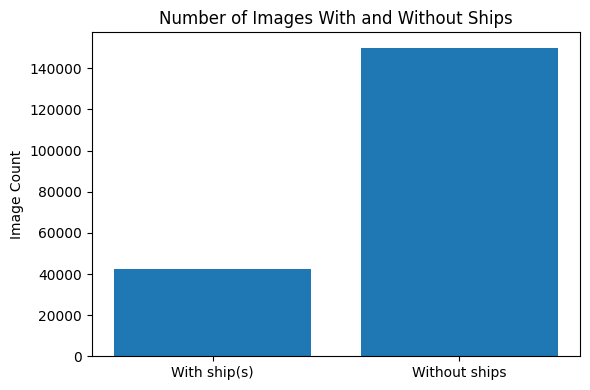

In [10]:
labels = ["With ship(s)", "Without ships"]
values = [pics_with_ship_count, pics_without_ship_count]

plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.title("Number of Images With and Without Ships")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()

In [11]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers, Model
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import Sequence

2025-11-26 15:42:45.378924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764171765.562244      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764171765.616383      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [12]:
IMG_SIZE = 256
DATASET_PATH = "/kaggle/input/airbus-ship-detection/"

In [13]:
class SegmentationDataGenerator(Sequence):
    def __init__(self, image_dir, mask_csv, batch_size=4, img_size=768,
                 file_list=None, augment=False, shuffle=True):
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_size = img_size        # végső kép és maszk méret
        self.original_size = 768        # Airbus dataset fix mérete
        
        self.augment = augment
        self.shuffle = shuffle

        if file_list is None:
            # fallback: az összes file, ha nincs megadva lista
            self.image_files = sorted(os.listdir(self.image_dir))
        else:
            # explicit lista
            self.image_files = list(file_list)

        self.mask_df = pd.read_csv(mask_csv)
        self.mask_groups = self.mask_df.groupby("ImageId")
        self.indexes = np.arange(len(self.image_files))
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_files) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, idx):
        batch_idx = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_files = [self.image_files[i] for i in batch_idx]

        images = []
        masks = []

        for fname in batch_files:
            # ------------------------------
            # IMAGE
            # ------------------------------
            img_path = os.path.join(self.image_dir, fname)
            image = load_img(img_path, target_size=(self.img_size, self.img_size))
            image = img_to_array(image) / 255.0

            # ------------------------------
            # MASK
            # ------------------------------
            # Az Airbus CSV mindig 768x768 RLE!
            if fname in self.mask_groups.groups:
                rles = self.mask_groups.get_group(fname)["EncodedPixels"]
            else:
                rles = []

            # maszk mindig 768x768
            mask = np.zeros((self.original_size, self.original_size), dtype=np.float32)

            for rle in rles:
                if pd.isna(rle):
                    continue
                mask += self.rle_decode_768(rle)

            mask = np.clip(mask, 0, 1)

            # ha kisebb img_size -> resize
            if self.img_size != self.original_size:
                mask = tf.image.resize(
                    mask[..., np.newaxis],
                    (self.img_size, self.img_size),
                    method="nearest"
                ).numpy()
            else:
                mask = mask[..., np.newaxis]

            images.append(image)
            masks.append(mask)

        return np.array(images), np.array(masks)
    
    def rle_decode_768(self, mask_rle):
        """
        RLE dekódolás fix 768*768
        """
        img = np.zeros(self.original_size * self.original_size, dtype=np.uint8)
        s = list(map(int, mask_rle.split()))
        starts, lengths = s[0::2], s[1::2]
        starts = np.array(starts) - 1
        ends = starts + lengths

        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1

        return img.reshape((self.original_size, self.original_size), order='F')


In [14]:
gen = SegmentationDataGenerator(DATASET_PATH+"train_v2",DATASET_PATH+"train_ship_segmentations_v2.csv",batch_size=1, img_size=IMG_SIZE)

In [15]:
import numpy as np

def show_random_samples_from_gen(gen, num_samples=20):
    total = len(gen)
    indices = np.random.choice(total, size=num_samples, replace=False)

    for idx in indices:
        X, y = gen[idx]
        img = X[0]
        mask = y[0]

        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.title(f"Image #{idx}")
        plt.imshow(img)
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.title("Mask")
        plt.imshow(mask[:,:,0], cmap="gray")
        plt.axis("off")

        plt.show()


I0000 00:00:1764171786.503606      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


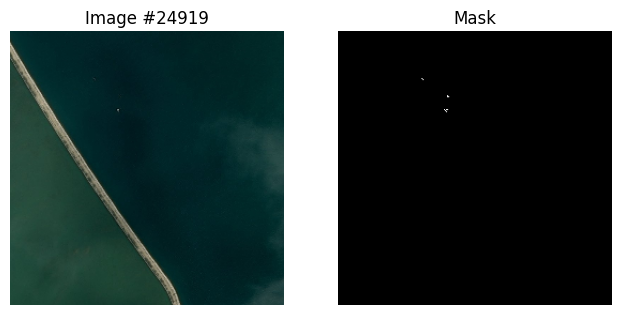

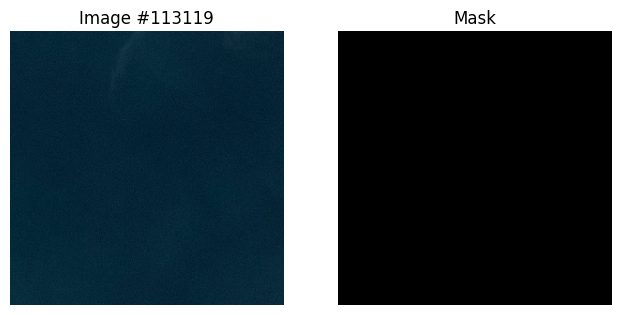

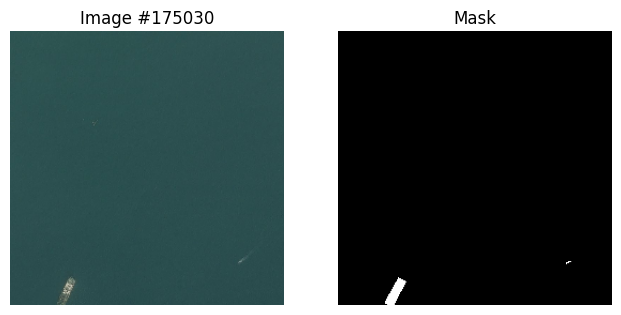

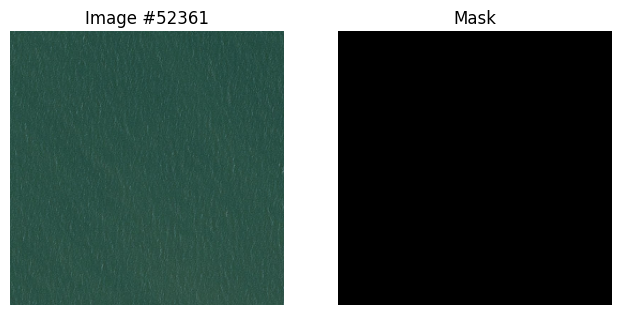

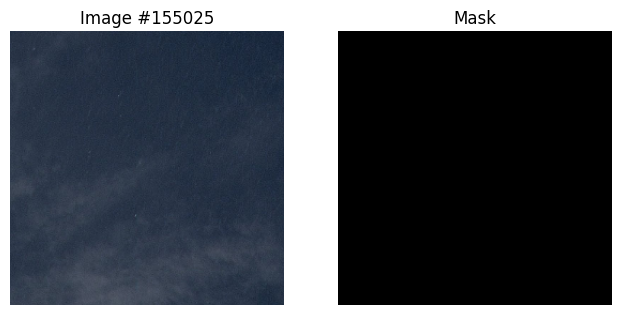

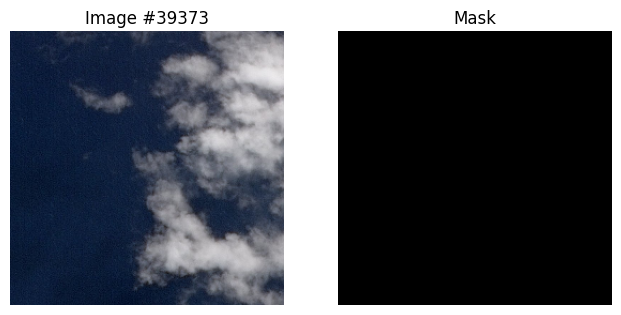

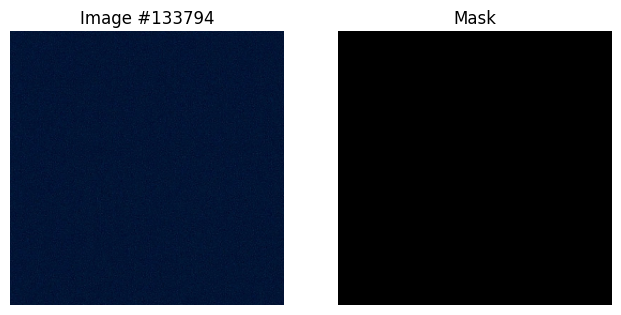

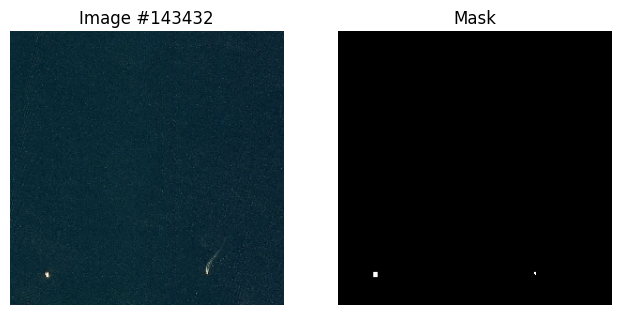

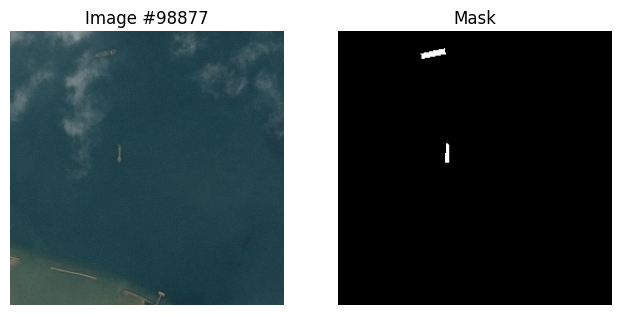

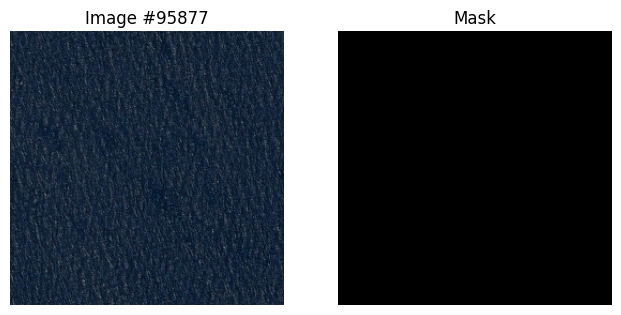

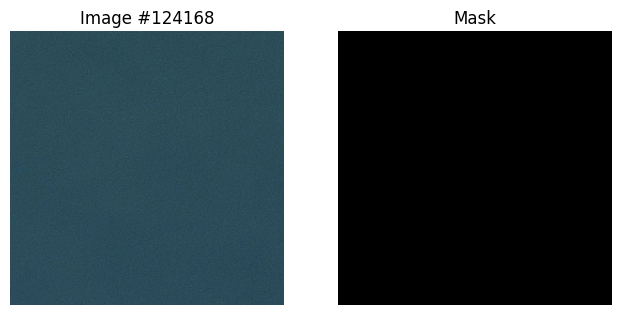

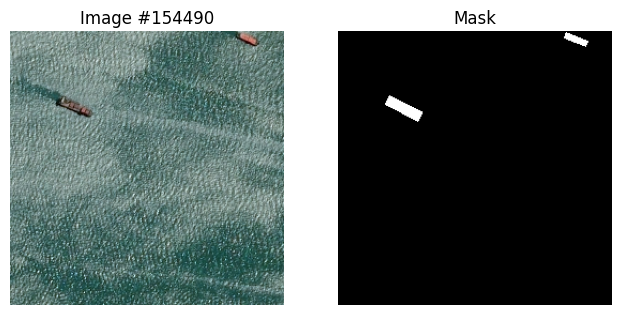

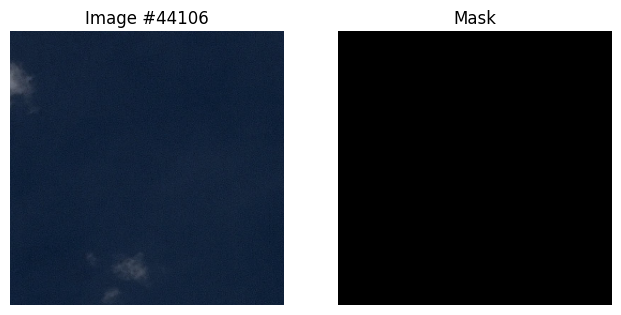

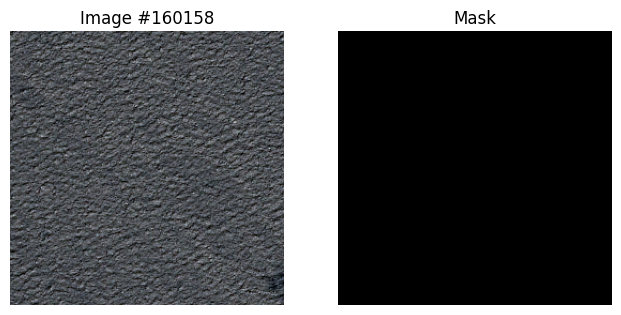

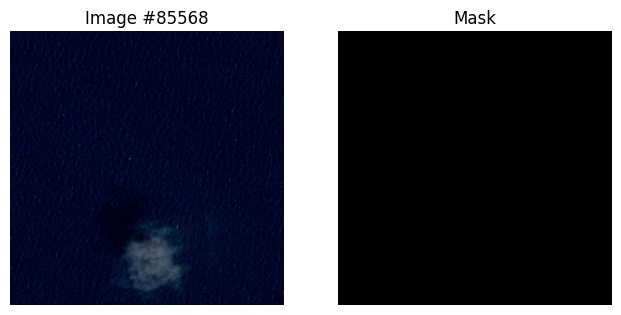

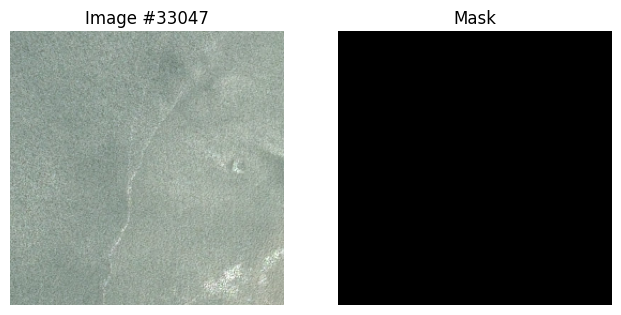

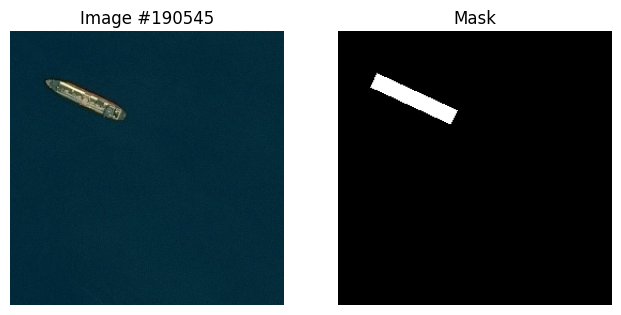

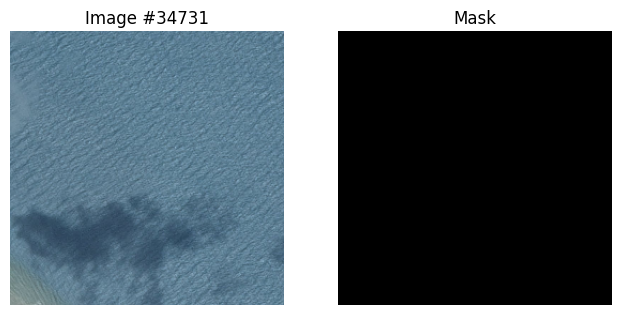

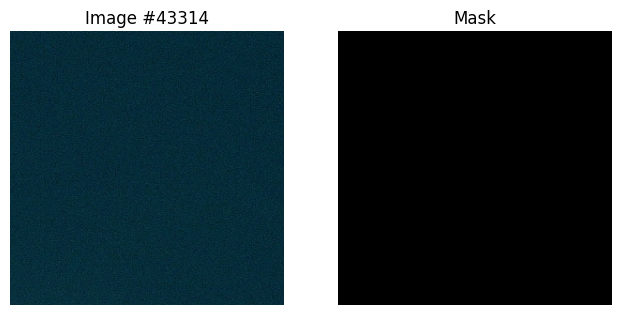

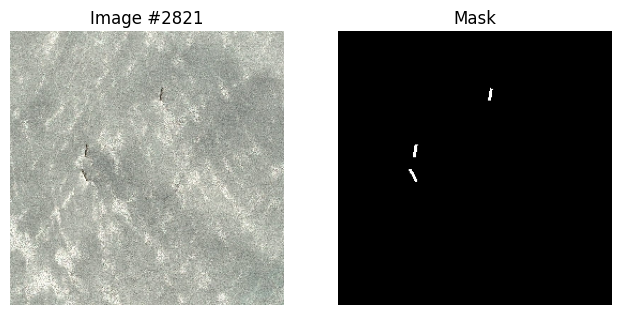

In [16]:
show_random_samples_from_gen(gen, num_samples=20)


In [17]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x


def encoder_block(x, filters):
    f = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(f)
    return f, p


def decoder_block(x, skip, filters):
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x



def build_unet():
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d4)

    return Model(inputs, outputs)

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [19]:
IMAGE_DIR = os.path.join(DATASET_PATH, "train_v2")
MASK_CSV = os.path.join(DATASET_PATH, "train_ship_segmentations_v2.csv")
all_files = os.listdir(IMAGE_DIR)
NUM_IMAGES = 15000


In [20]:
df_summary = (
    df.groupby("ImageId", as_index=False)["EncodedPixels"]
      .agg(ship_count=lambda s: s.notna().sum())
)

In [21]:
all_files = sorted(os.listdir(IMAGE_DIR))[:NUM_IMAGES]

df_subset = df_summary[df_summary["ImageId"].isin(all_files)].copy()
df_subset["has_ship"] = (df_subset["ship_count"] > 0).astype(int)


train_val_df, test_df = train_test_split(
    df_subset,
    test_size=0.15,
    stratify=df_subset["has_ship"],
    random_state=42
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1765,
    stratify=train_val_df["has_ship"],
    random_state=42
)

In [22]:
empty     = train_df[train_df["has_ship"] == 0]
non_empty = train_df[train_df["has_ship"] == 1]

empty_sample = empty.sample(len(non_empty), random_state=42)

balanced_train_df = pd.concat([empty_sample, non_empty]).sample(
    frac=1.0, random_state=42
)

train_files = balanced_train_df["ImageId"].values
val_files   = val_df["ImageId"].values
test_files  = test_df["ImageId"].values


In [23]:
print("Train képek:", len(train_files))
print("Val képek:", len(val_files))
print("Test képek: ", len(test_files))

Train képek: 4644
Val képek: 2251
Test képek:  2250


In [25]:
BATCH_SIZE = 16

train_gen = SegmentationDataGenerator(
    image_dir=IMAGE_DIR,
    mask_csv=MASK_CSV,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    file_list=train_files,
    augment=False,
    shuffle=True,
)

val_gen = SegmentationDataGenerator(
    image_dir=IMAGE_DIR,
    mask_csv=MASK_CSV,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    file_list=val_files,
    augment=False,
    shuffle=False,
)

test_gen = SegmentationDataGenerator(
    image_dir=IMAGE_DIR,
    mask_csv=MASK_CSV,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    file_list=test_files,
    augment=False,
    shuffle=False,
)


In [26]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)          
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_pred_f = K.cast(y_pred_f > 0.5, "float32")
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [27]:
from tensorflow.keras.losses import BinaryCrossentropy

bce = BinaryCrossentropy()

def bce_dice_loss(y_true, y_pred):
    return bce(y_true, y_pred) + (1.0 - dice_coef(y_true, y_pred))


In [28]:
def f2_score_pixel(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_pred_f = K.cast(y_pred_f > 0.5, "float32")

    tp = K.sum(y_true_f * y_pred_f)
    fp = K.sum((1 - y_true_f) * y_pred_f)
    fn = K.sum(y_true_f * (1 - y_pred_f))

    beta2 = 4.0  # F2 -> beta^2 = 4
    return (1 + beta2) * tp / ((1 + beta2) * tp + beta2 * fn + fp + smooth)


In [29]:
model = build_unet()
model.summary()

model.compile(
    optimizer="adam",
    loss=bce_dice_loss,
    metrics=[dice_coef, iou_score, f2_score_pixel]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
checkpoint = ModelCheckpoint(
    "unet_airbus_best.keras",
    monitor="val_loss",
    save_best_only=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True,
)

callbacks = [checkpoint, reduce_lr, early_stop]

In [31]:
EPOCHS = 30

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1764172012.631546     109 service.cc:148] XLA service 0x7e8ec8002880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764172012.632242     109 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764172013.562619     109 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764172054.128135     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - dice_coef: 0.0260 - f2_score_pixel: 0.0179 - iou_score: 0.0126 - loss: 1.0727

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


290/290 ━━━━━━━━━━━━━━━━━━━━ 301s 876ms/step - dice_coef: 0.0261 - f2_score_pixel: 0.0180 - iou_score: 0.0127 - loss: 1.0726 - val_dice_coef: 0.0796 - val_f2_score_pixel: 0.0739 - val_iou_score: 0.0727 - val_loss: 0.9337 - learning_rate: 0.0010
Epoch 2/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 184s 636ms/step - dice_coef: 0.1009 - f2_score_pixel: 0.1038 - iou_score: 0.0673 - loss: 0.9373 - val_dice_coef: 0.0953 - val_f2_score_pixel: 0.0829 - val_iou_score: 0.0660 - val_loss: 0.9188 - learning_rate: 0.0010
Epoch 3/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 184s 634ms/step - dice_coef: 0.1650 - f2_score_pixel: 0.1682 - iou_score: 0.1068 - loss: 0.8670 - val_dice_coef: 0.1443 - val_f2_score_pixel: 0.1388 - val_iou_score: 0.0985 - val_loss: 0.8736 - learning_rate: 0.0010
Epoch 4/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 184s 634ms/step - dice_coef: 0.2121 - f2_score_pixel: 0.2107 - iou_score: 0.1363 - loss: 0.8164 - val_dice_coef: 0.1788 - val_f2_score_pixel: 0.1626 - val_iou_score: 0.1182 - val_loss: 0.8352 - learning_

In [32]:
from tensorflow.keras.models import load_model
model = load_model(
    "unet_airbus_best.keras",
    compile=False
)


In [35]:
import random

def show_predictions_random_batch(generator, num_images=5):
    shown = 0

    while shown < num_images:
        batch_index = random.randint(0, len(generator)-1)

        X, y = generator[batch_index]
        preds = model.predict(X, verbose=0)

        batch_size = X.shape[0]

        for i in range(batch_size):
            if shown >= num_images:
                break

            img = X[i]
            true_mask = y[i][:,:,0]
            pred_mask = preds[i][:,:,0]

            plt.figure(figsize=(12,4))

            plt.subplot(1,3,1)
            plt.title("Image")
            plt.imshow(img)

            plt.subplot(1,3,2)
            plt.title("True Mask")
            plt.imshow(true_mask, cmap="gray")

            plt.subplot(1,3,3)
            plt.title("Predicted")
            plt.imshow(pred_mask, cmap="gray")

            plt.show()

            shown += 1


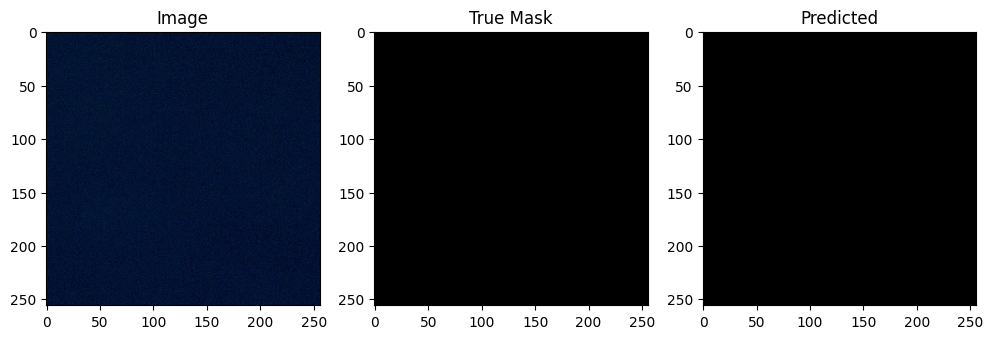

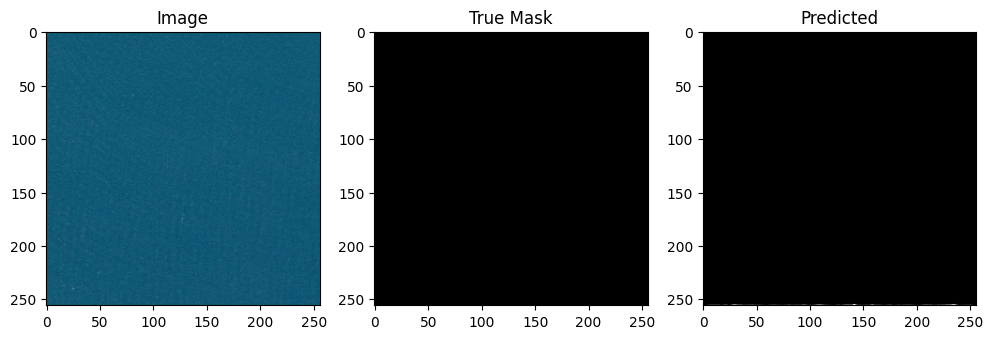

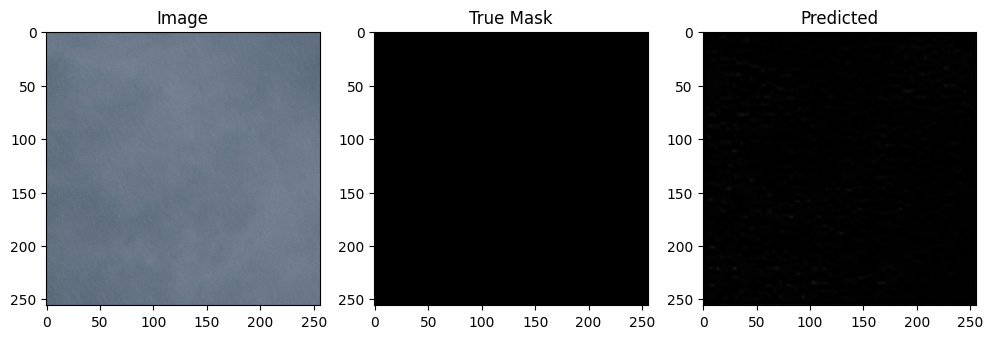

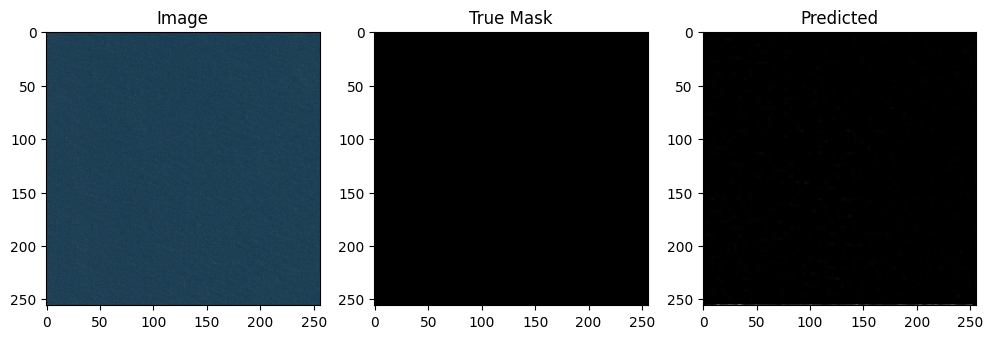

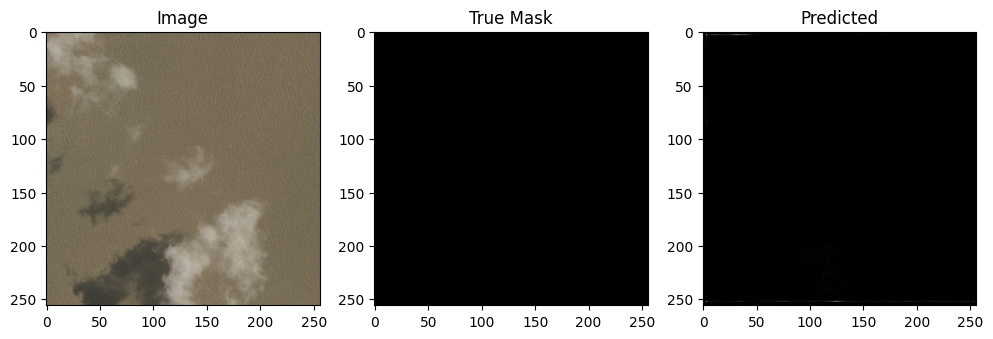

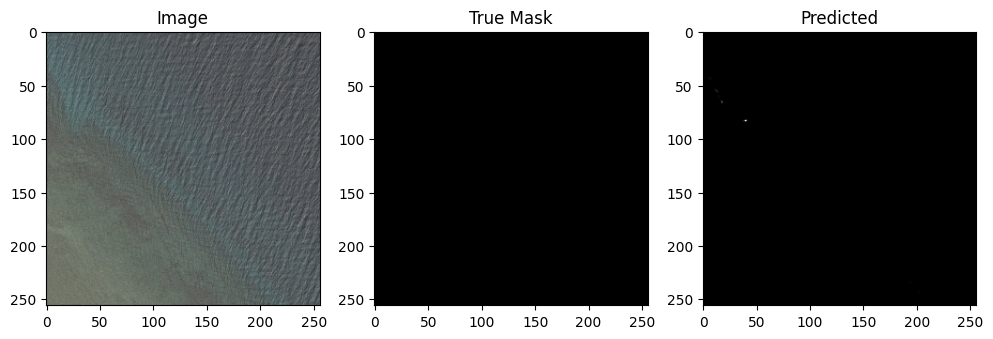

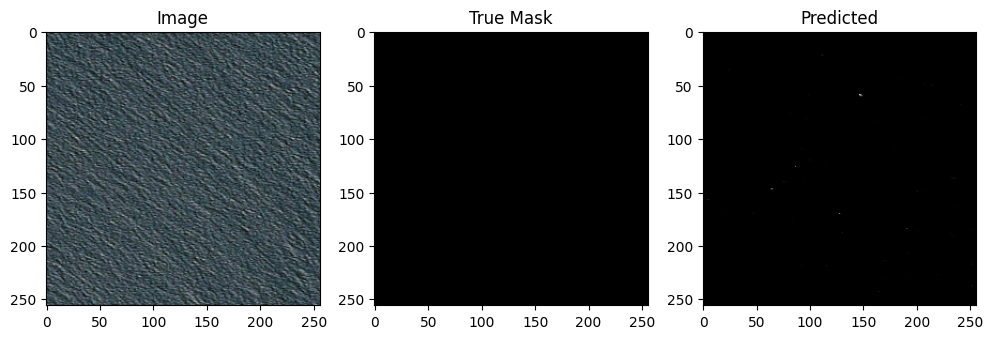

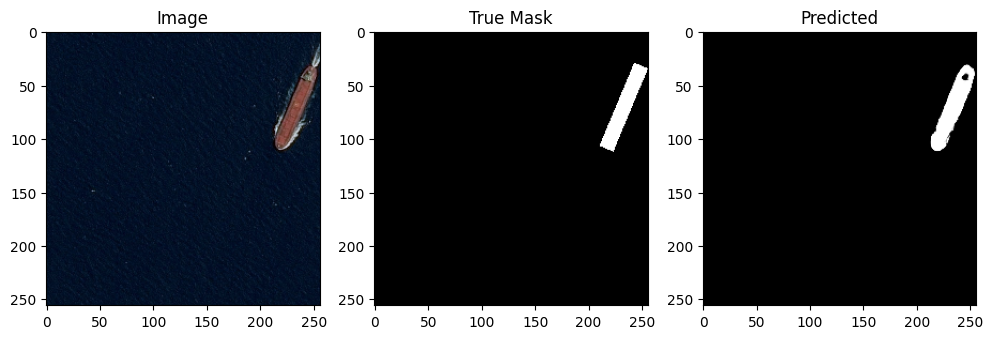

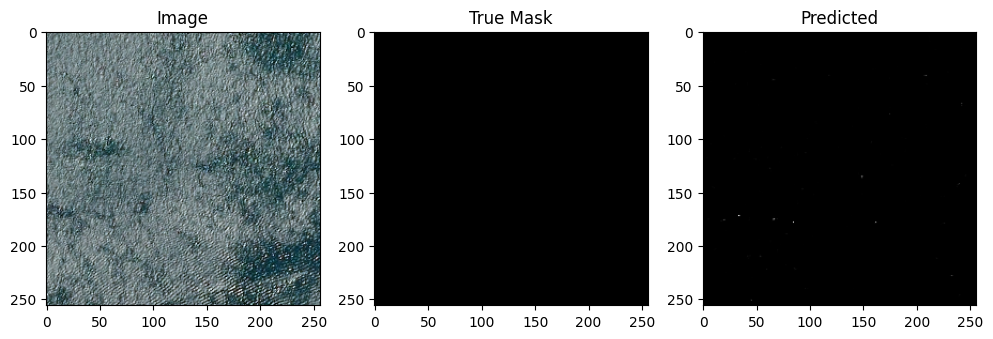

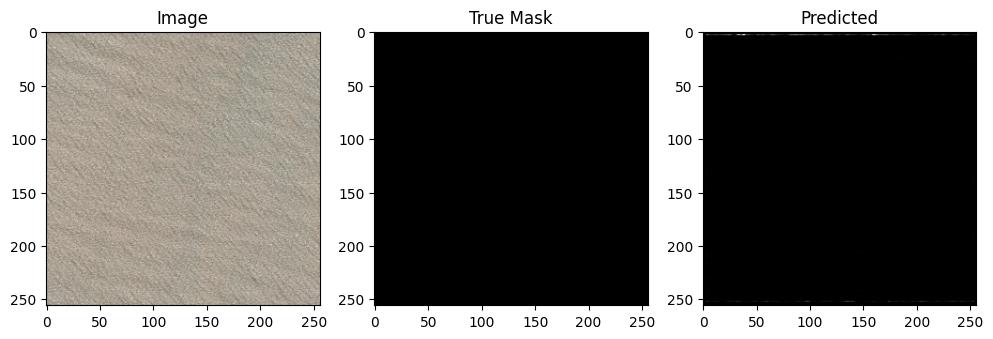

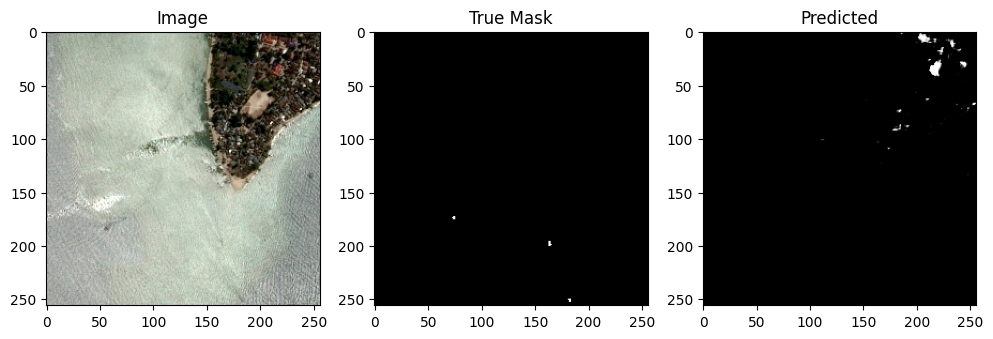

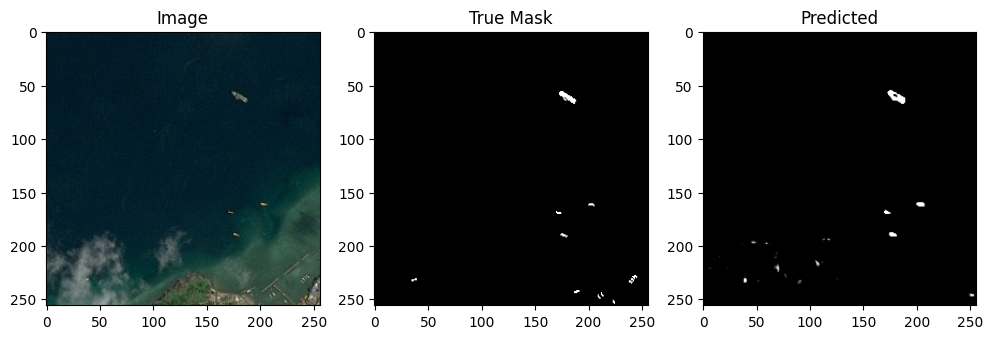

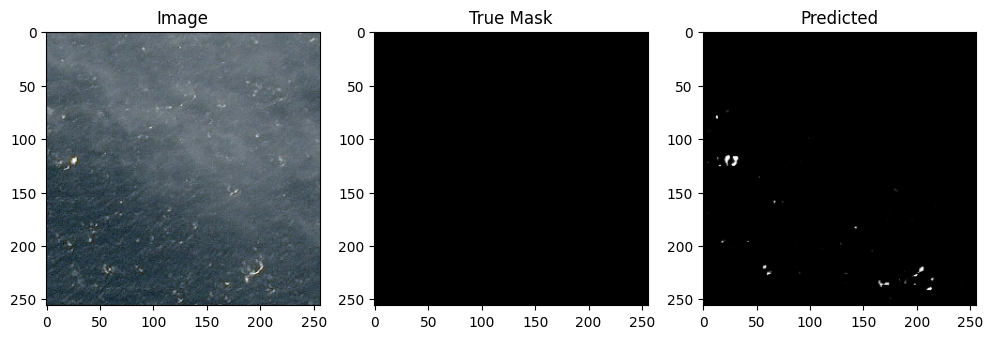

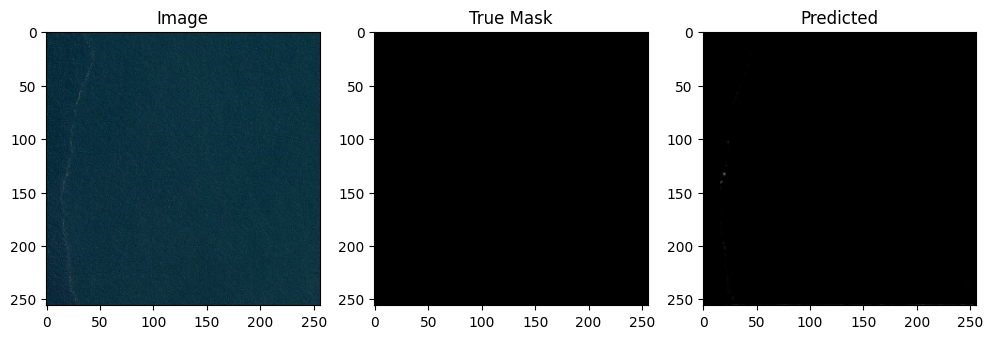

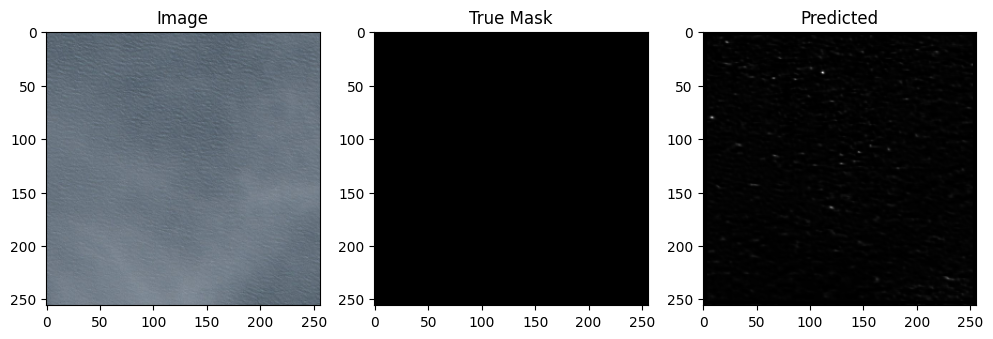

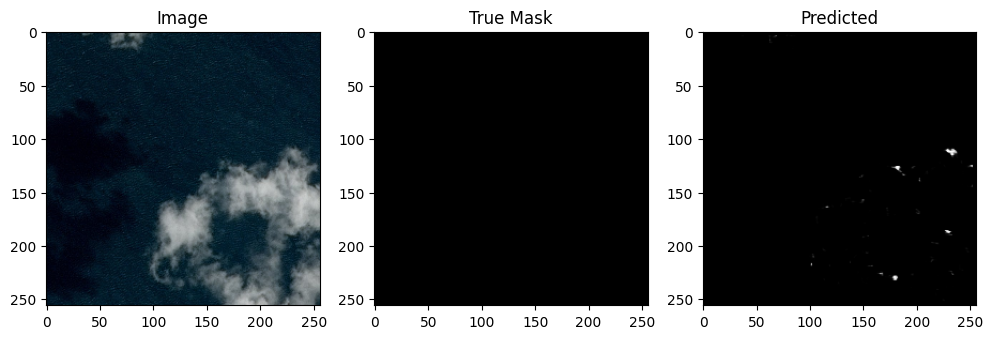

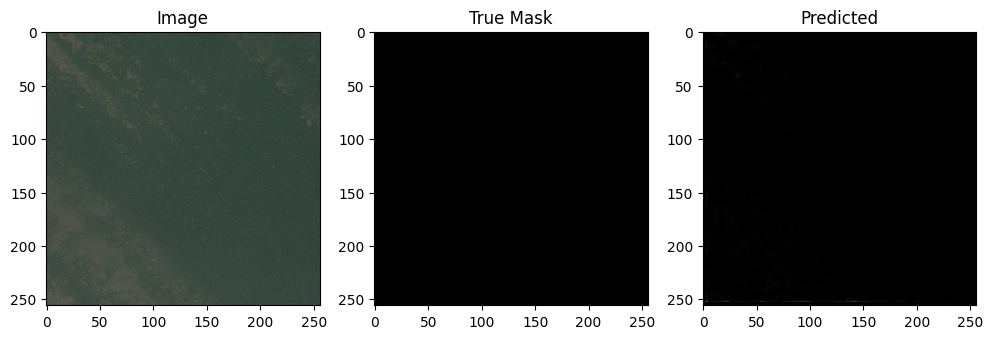

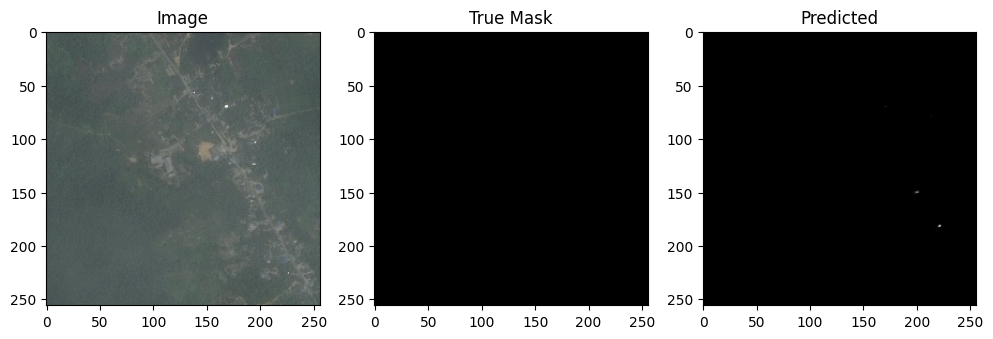

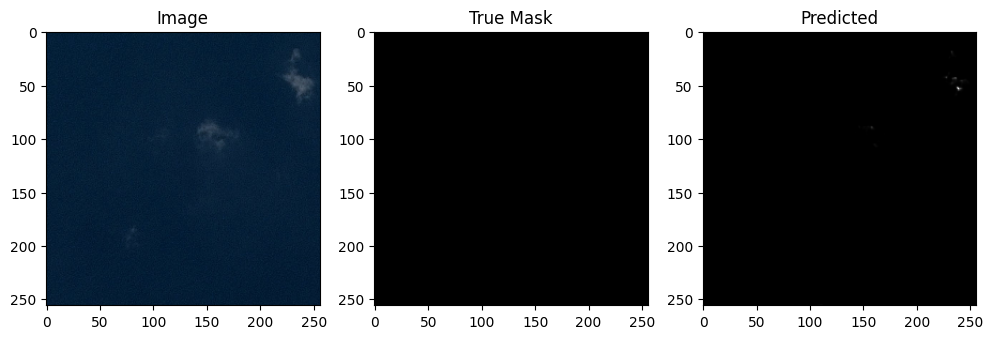

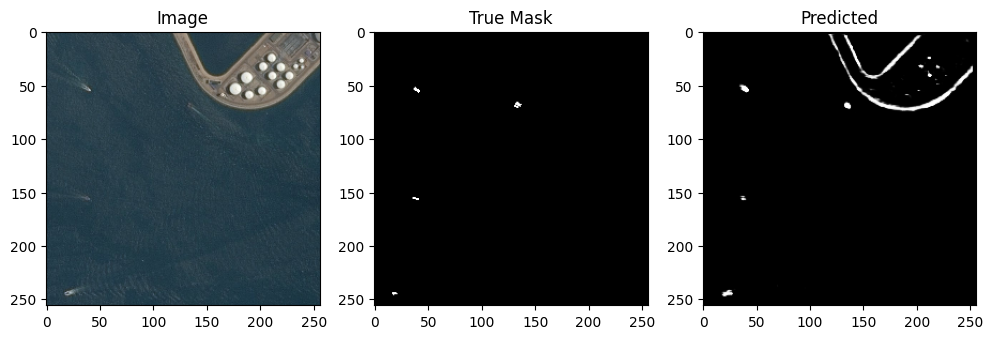

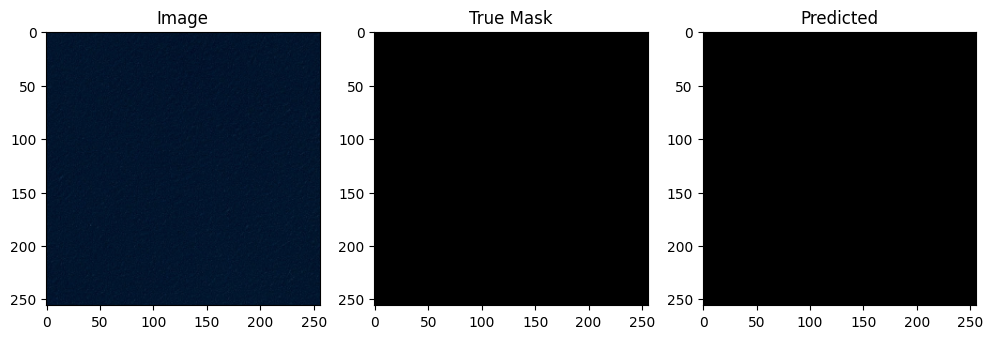

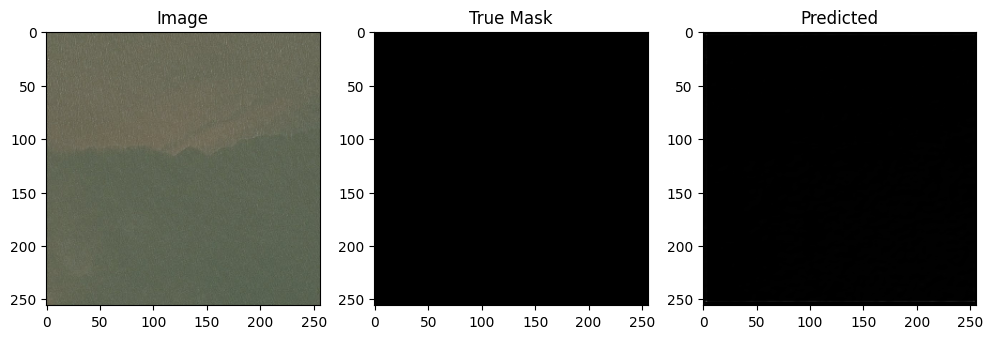

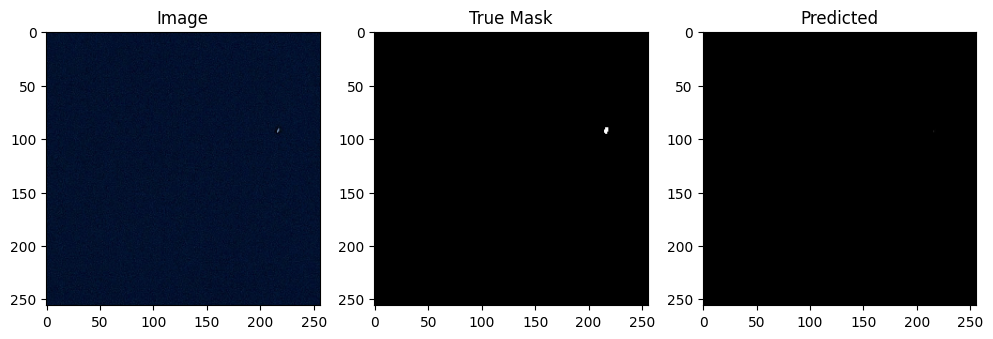

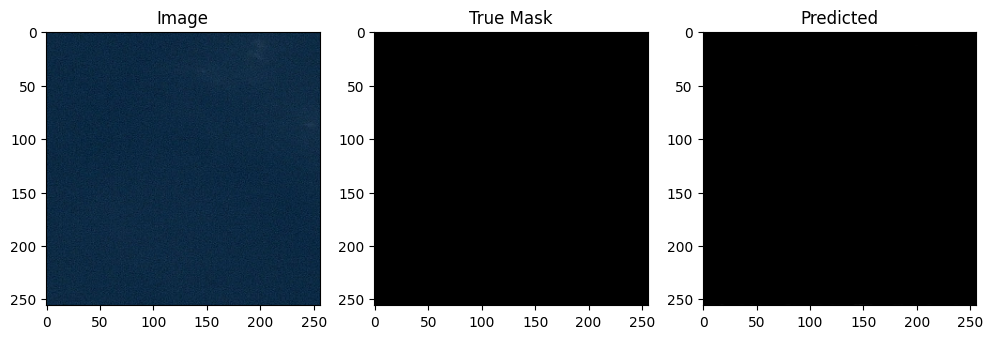

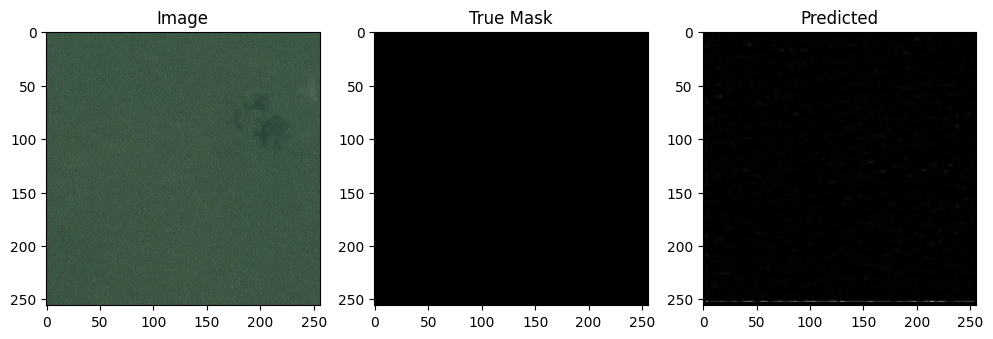

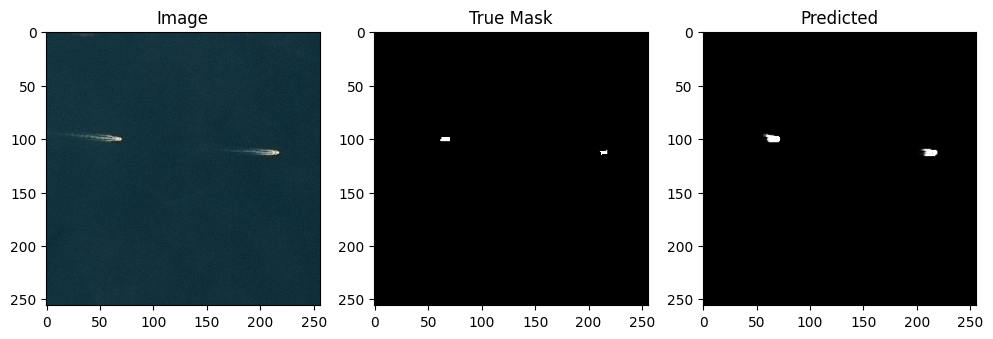

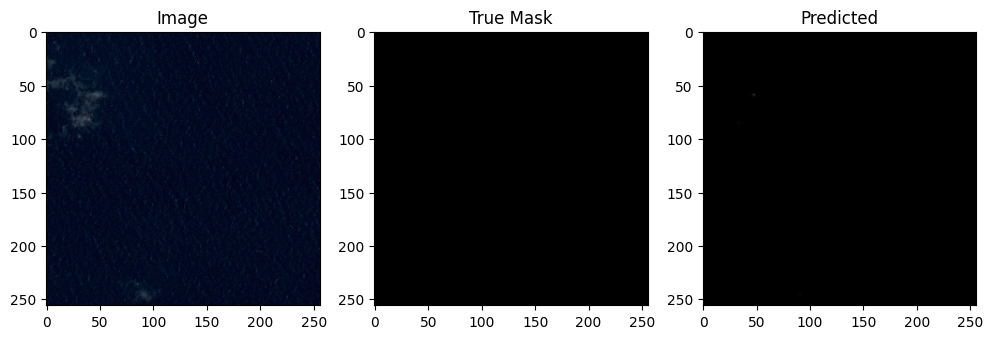

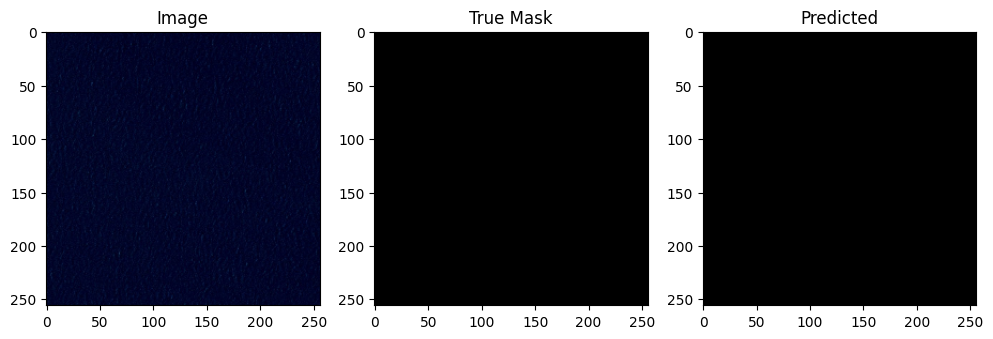

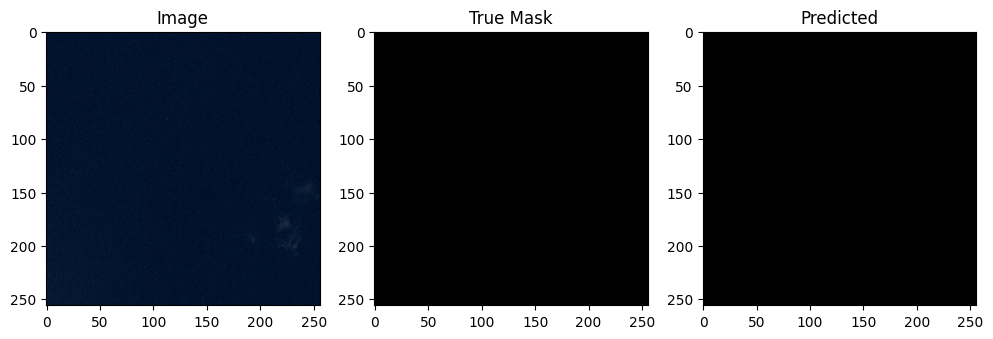

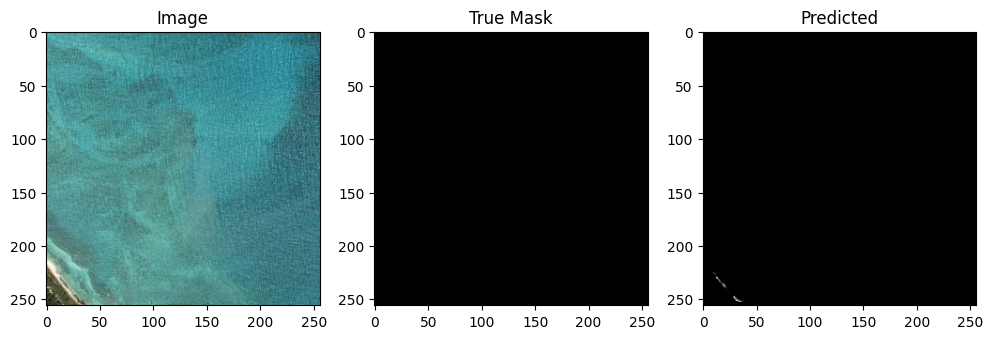

In [37]:
show_predictions_random_batch(val_gen, num_images=30)


# Kiértékelés

In [44]:
import cv2
def iou(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)

    inter = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0.0
    return inter / union


def extract_objects(binary_mask):
    binary_mask = binary_mask.astype(np.uint8)
    num_labels, labels = cv2.connectedComponents(binary_mask)

    objects = []
    for label in range(1, num_labels):  # 0 = háttér
        obj_mask = (labels == label)
        objects.append(obj_mask)

    return objects


In [39]:
def f2_score_per_image(gt_mask, pred_mask):
    thresholds = np.arange(0.5, 1.0, 0.05)

    gt_objects   = extract_objects(gt_mask)
    pred_objects = extract_objects(pred_mask)

    # Speciális esetek
    if len(gt_objects) == 0 and len(pred_objects) == 0:
        return 1.0   

    if len(gt_objects) == 0 and len(pred_objects) > 0:
        return 0.0   

    f2_scores = []

    for t in thresholds:
        TP = 0
        FP = 0

        matched_gt = set()

        for pred_obj in pred_objects:
            best_iou = 0.0
            best_gt_idx = None

            # keressük a legjobb GT match-et
            for i, gt_obj in enumerate(gt_objects):
                if i in matched_gt:
                    continue
                iou_val = iou(pred_obj, gt_obj)
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_gt_idx = i

            if best_iou >= t and best_gt_idx is not None:
                TP += 1
                matched_gt.add(best_gt_idx)
            else:
                FP += 1

        FN = len(gt_objects) - len(matched_gt)

        beta2 = 4.0  # beta=2 => beta^2 = 4
        denom = (1 + beta2) * TP + beta2 * FN + FP
        if denom == 0:
            f2_t = 0.0
        else:
            f2_t = (1 + beta2) * TP / denom

        f2_scores.append(f2_t)

    return float(np.mean(f2_scores))


In [45]:
def evaluate_dataset_competition_f2(model, test_gen, pred_threshold=0.5):
    all_scores = []

    for batch_idx in range(len(test_gen)):
        X, y = test_gen[batch_idx]            # X: képek, y: GT maszkok
        preds = model.predict(X, verbose=0)   # valószínűségi maszkok

        # Binarizálás
        preds_bin = (preds > pred_threshold).astype(np.uint8)

        batch_size = X.shape[0]

        for i in range(batch_size):
            gt = y[i]
            pr = preds_bin[i]

            # ha (H, W, 1) alakú, lapítsuk 2D-re
            if gt.ndim == 3:
                gt = gt[..., 0]
            if pr.ndim == 3:
                pr = pr[..., 0]

            score = f2_score_per_image(gt > 0.5, pr)  # GT-t is binárissá tesszük
            all_scores.append(score)

    return float(np.mean(all_scores))


In [46]:
test_f2 = evaluate_dataset_competition_f2(model, test_gen, pred_threshold=0.5)
print("Competition-style F2 a test seten:", test_f2)


Competition-style F2 a test seten: 0.6465899388181066
